# Introduction to Machine Learning Project Code

The goal is to predict the median house price of each block using the training data.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

raw_data = pd.read_excel("/content/drive/MyDrive/train.xlsx", usecols="B:K")

Using pandas, we read the train data in xlsx format as a two-dimensional tabular data, which is called a Dataframe. We use columns B:K, which are the labeled columns of the data.

Now lets look at what is in the Dataframe.

## Analysis of Data and Feature Selection

In [2]:
raw_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,target
0,-121.89,37.29,38,1568,351.0,710,339,2.7042,<1H OCEAN,286600
1,-121.93,37.05,14,679,108.0,306,113,6.4214,<1H OCEAN,340600
2,-117.20,32.77,31,1952,471.0,936,462,2.8621,NEAR OCEAN,196900
3,-119.61,36.31,25,1847,371.0,1460,353,1.8839,INLAND,46300
4,-118.59,34.23,17,6592,1525.0,4459,1463,3.0347,<1H OCEAN,254500
...,...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46,1271,236.0,573,210,4.9312,INLAND,240200
16508,-117.56,33.88,40,1196,294.0,1052,258,2.0682,INLAND,113000
16509,-116.40,34.09,9,4855,872.0,2098,765,3.2723,INLAND,97800
16510,-118.01,33.82,31,1960,380.0,1356,356,4.0625,<1H OCEAN,225900


Check for any data that is not numerical

In [3]:
raw_data.dtypes

longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms        float64
population              int64
households              int64
median_income         float64
ocean_proximity        object
target                  int64
dtype: object

Observing the data read from the excel file, we see that all feature categories are numerical except 'ocean_proximity'. The values of 'ocean_proximity' should be changed to numerical values before using them to train the model.

Check for unique values of 'ocean_proximity.

In [4]:
raw_data['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

We see that 'ocean_proximity' has five distinct string values('<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND'). Ocean proximity should have a correlation with house prices. Therefore, the string values are changed into integer values of increasing order according to the decreasing proximity to the ocean.

In [5]:
obj_to_num = dict()

obj_to_num['ISLAND'] = 0
obj_to_num['NEAR OCEAN'] = 1
obj_to_num['NEAR BAY'] = 1
obj_to_num['<1H OCEAN'] = 2
obj_to_num['INLAND'] = 3

The 'ocean_proximity' is replaced with corresponding integer values. Now, the data is completely numerical.

In [6]:
numerical_data = raw_data.replace(obj_to_num)
numerical_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,target
0,-121.89,37.29,38,1568,351.0,710,339,2.7042,2,286600
1,-121.93,37.05,14,679,108.0,306,113,6.4214,2,340600
2,-117.20,32.77,31,1952,471.0,936,462,2.8621,1,196900
3,-119.61,36.31,25,1847,371.0,1460,353,1.8839,3,46300
4,-118.59,34.23,17,6592,1525.0,4459,1463,3.0347,2,254500
...,...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46,1271,236.0,573,210,4.9312,3,240200
16508,-117.56,33.88,40,1196,294.0,1052,258,2.0682,3,113000
16509,-116.40,34.09,9,4855,872.0,2098,765,3.2723,3,97800
16510,-118.01,33.82,31,1960,380.0,1356,356,4.0625,2,225900


Check for basic statistics on the distribution of numerical data. It is difficult to analyze data in this fashion, so some useful methods will be used to visualize the data below.

In [7]:
numerical_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,target
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,2.078004,206990.920724
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,0.744085,115703.014830
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,0.000000,14999.000000
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,2.000000,119800.000000
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,2.000000,179500.000000
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,3.000000,263900.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,3.000000,500001.000000


Now we check if there are data with empty values.

In [8]:
numerical_data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
target                  0
dtype: int64

The empty values are all in 'total_bedrooms'. These empty values have to be either removed or replace/filled with numerical values. We will see if there is a special characteristic associated with data with empty values by comparing the distribution of data.

In [9]:
with_empty = numerical_data.loc[numerical_data['total_bedrooms'].isna()].copy()
with_empty.dropna(axis='columns', inplace=True)
with_empty

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,target
113,-118.30,34.07,18,3759,3296,1462,2.2708,2,175000
116,-117.86,34.01,16,4632,3038,727,5.1762,2,264400
216,-121.97,37.35,30,1955,999,386,4.6328,2,287100
303,-117.30,34.05,6,2155,1039,391,1.6675,3,95800
321,-122.79,38.48,7,6837,3468,1405,3.1662,2,191000
...,...,...,...,...,...,...,...,...,...
15722,-118.28,34.25,29,2559,1886,769,2.6036,2,162100
16063,-118.37,34.07,50,2519,1117,516,4.3667,2,405600
16124,-117.76,34.04,34,1914,1564,328,2.8347,3,115800
16326,-119.75,34.45,6,2864,1404,603,5.5073,1,263800


In [10]:
non_empty = numerical_data.loc[numerical_data['total_bedrooms'].notna()].copy()
non_empty

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,target
0,-121.89,37.29,38,1568,351.0,710,339,2.7042,2,286600
1,-121.93,37.05,14,679,108.0,306,113,6.4214,2,340600
2,-117.20,32.77,31,1952,471.0,936,462,2.8621,1,196900
3,-119.61,36.31,25,1847,371.0,1460,353,1.8839,3,46300
4,-118.59,34.23,17,6592,1525.0,4459,1463,3.0347,2,254500
...,...,...,...,...,...,...,...,...,...,...
16507,-118.13,34.20,46,1271,236.0,573,210,4.9312,3,240200
16508,-117.56,33.88,40,1196,294.0,1052,258,2.0682,3,113000
16509,-116.40,34.09,9,4855,872.0,2098,765,3.2723,3,97800
16510,-118.01,33.82,31,1960,380.0,1356,356,4.0625,2,225900


The distribution of data is visualized as binned histograms.

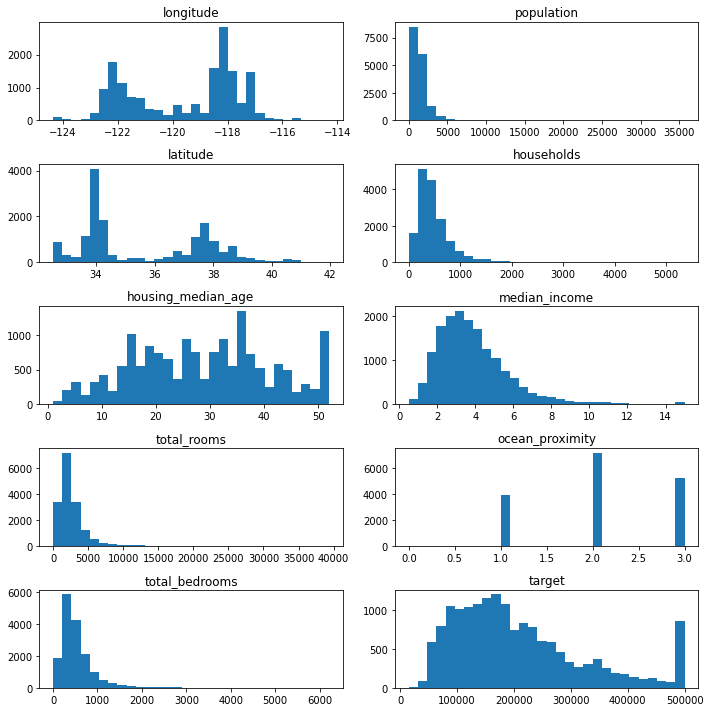

In [11]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))

for idx, column_name in enumerate(non_empty.columns):
  axs[idx%5, int(idx/5)].hist(non_empty[column_name], bins=30)
  axs[idx%5, int(idx/5)].set_title(column_name)

fig.tight_layout()
plt.show()

We now see the distribution of data with empty entries in the 'total_bedrooms' column.

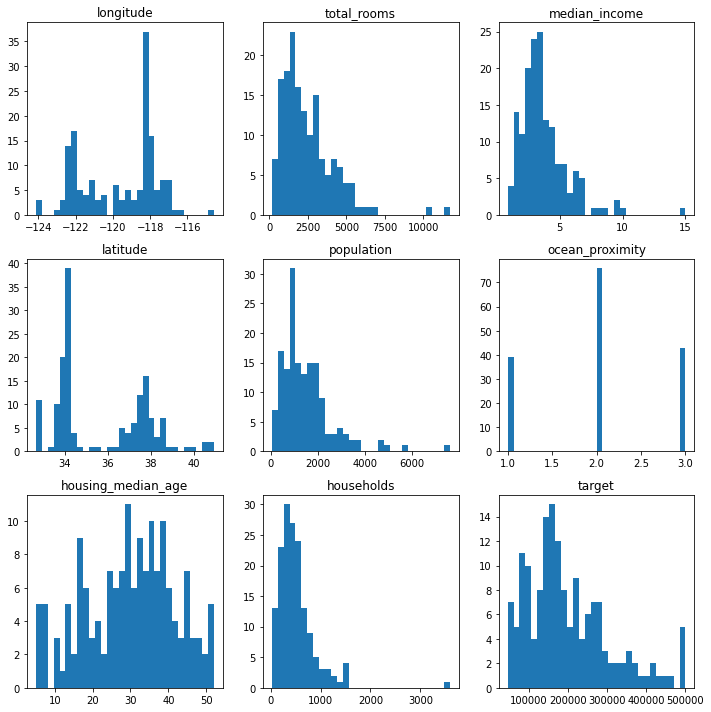

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))

for idx, column_name in enumerate(with_empty.columns):
  axs[idx%3, int(idx/3)].hist(with_empty[column_name], bins=30)
  axs[idx%3, int(idx/3)].set_title(column_name)

fig.tight_layout()
plt.show()

The data with empty entries do not have unique characteristics that differ from the rest of the data. The data with empty entries will be removed.

In [13]:
numerical_data.dropna(inplace=True)

Now the we use the correlation coefficient matrix to see if there is any linear relation between each pair of variables.

In [14]:
corr_matrix = numerical_data.corr()
corr_matrix['target']

longitude            -0.046983
latitude             -0.143130
housing_median_age    0.114803
total_rooms           0.134372
total_bedrooms        0.047689
population           -0.027586
households            0.063657
median_income         0.687428
ocean_proximity      -0.431521
target                1.000000
Name: target, dtype: float64

We can see that the 'ocean_proximity' is negatively correlated to 'target' and 'median_income' is positively correlated to 'target'.

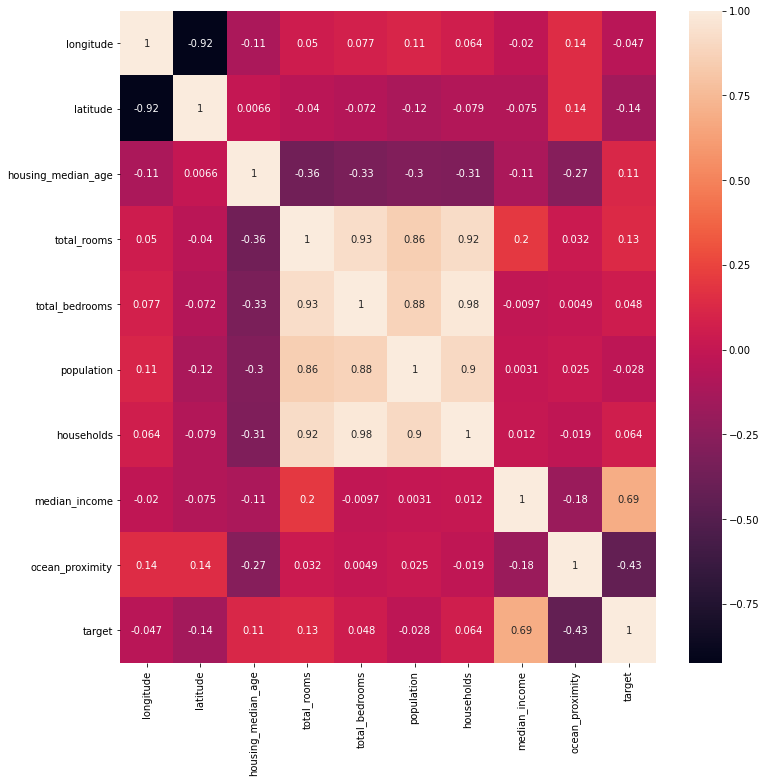

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True)

## Linear Regression Using All Features

In [16]:
target = numerical_data['target']
feature = numerical_data.drop('target', axis='columns')

We attempt to fit the data to a linear regression model.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

Split the data into train and test data.

In [18]:
train_feature, test_feature, train_target, test_target = train_test_split(feature, target, test_size=0.25, random_state=1)

In [19]:
linreg_model = LinearRegression()

In [20]:
cross_score = cross_val_score(linreg_model, train_feature, train_target, cv=5)

In [21]:
cross_score

array([0.63129255, 0.66013758, 0.64081252, 0.5984954 , 0.65017378])

In [22]:
linreg_model.fit(train_feature, train_target)
linreg_model.score(test_feature, test_target)

0.6420426603756191

In [23]:
linreg_pred = linreg_model.predict(test_feature)
RMSE = mean_squared_error(test_target, linreg_pred)**0.5
print(RMSE)

69200.7770029132


## Linear Regression Using Linearly Independent Features 

In [24]:
target = numerical_data['target']
feature = numerical_data.drop(['target','total_bedrooms','population','households'], axis='columns')

In [25]:
train_feature2, test_feature2, train_target2, test_target2 = train_test_split(feature, target, test_size=0.25, random_state=1)

In [26]:
linreg_model2 = LinearRegression()

In [27]:
cross_score = cross_val_score(linreg_model2, train_feature2, train_target2, cv=5)

In [28]:
cross_score

array([0.58840193, 0.62374834, 0.60518492, 0.58898625, 0.61611557])

In [29]:
linreg_model2.fit(train_feature2, train_target2)
linreg_model2.score(test_feature2, test_target2)

0.6047760885868032

In [30]:
linreg2_pred = linreg_model2.predict(test_feature2)
RMSE2 = mean_squared_error(test_target2, linreg2_pred)**0.5
print(RMSE2)

72713.81668153137


## Linear Regression Using Feature Transform(Log Transformation)

Note that some features are highly skewed to the left. Log transformation will be used to relieve the skewed data closer to a normal distribution.

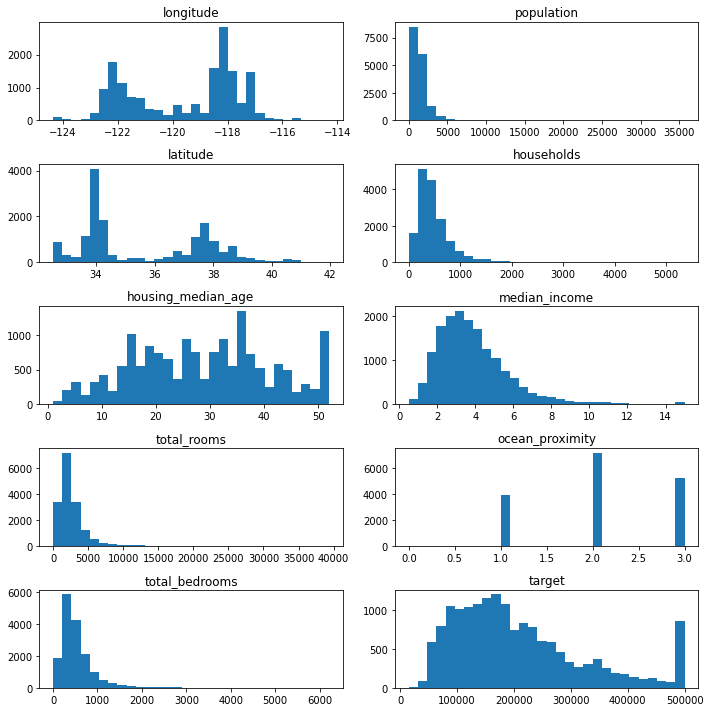

In [31]:
fig, axs = plt.subplots(5, 2, figsize=(10,10))

for idx, column_name in enumerate(numerical_data.columns):
  axs[idx%5, int(idx/5)].hist(numerical_data[column_name], bins=30)
  axs[idx%5, int(idx/5)].set_title(column_name)

fig.tight_layout()
plt.show()

Perform log transform.

In [32]:
target = numerical_data['target']
feature = numerical_data.drop(['target'], axis='columns')

In [33]:
feature['households'] = np.log(feature['households'])
feature['total_bedrooms'] = np.log(feature['total_bedrooms'])
feature['total_rooms'] = np.log(feature['total_rooms'])
feature['population'] = np.log(feature['population'])

The data after log transform is the following.

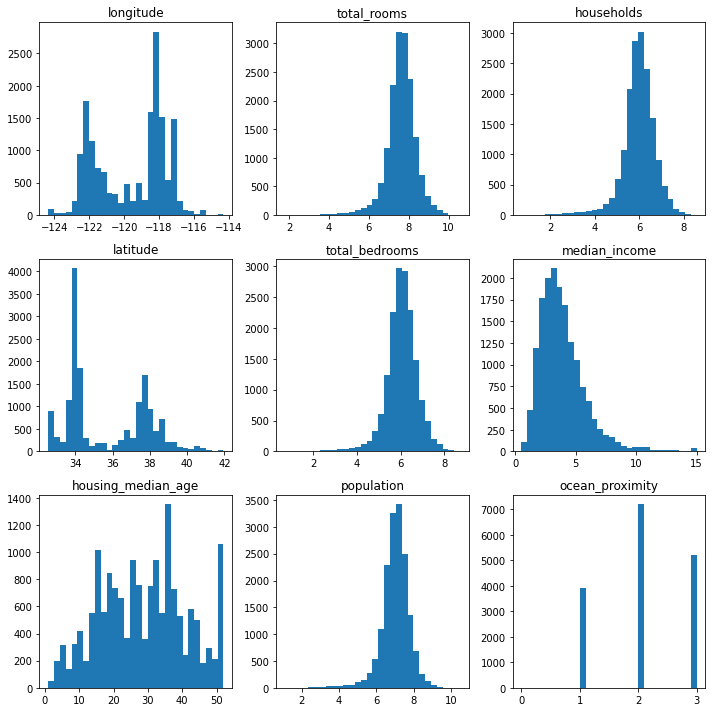

In [34]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))

for idx, column_name in enumerate(feature.columns):
  axs[idx%3, int(idx/3)].hist(feature[column_name], bins=30)
  axs[idx%3, int(idx/3)].set_title(column_name)

fig.tight_layout()
plt.show()

In [35]:
train_feature3, test_feature3, train_target3, test_target3 = train_test_split(feature, target, test_size=0.25, random_state=1)

In [36]:
logtrans_model = LinearRegression()

In [37]:
cross_score = cross_val_score(logtrans_model, train_feature3, train_target3, cv=5)

In [38]:
cross_score

array([0.64913294, 0.68552765, 0.66149183, 0.63980643, 0.67233433])

The accuracy of the linear regression model after log transform has increased about 3.3%

In [39]:
logtrans_model.fit(train_feature3, train_target3)
logtrans_model.score(test_feature3, test_target3)

0.6733438644218399

In [40]:
pred = logtrans_model.predict(test_feature3)
RMSE = mean_squared_error(test_target3, pred)**0.5
print(RMSE)

66105.9795557626


## Non-linear Regression

We use Bayesian Ridge and XGBoost regression to fit the data to see if it yields better accuracy.

In [41]:
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

### Polynomial Regression

Polynomial of degree 2 seems to the most optimal.

In [60]:
poly = PolynomialFeatures(degree = 2)
poly_fitted = poly.fit(feature)
poly_feat = poly.transform(feature)

In [61]:
train_feature4, test_feature4, train_target4, test_target4 = train_test_split(poly_feat, target, test_size=0.25, random_state=1)

In [62]:
poly_reg = LinearRegression()
cross_score = cross_val_score(poly_reg, train_feature4, train_target4, cv=5)

In [63]:
cross_score

array([0.65505042, 0.7490102 , 0.7333554 , 0.70879198, 0.73628271])

In [64]:
poly_reg.fit(train_feature4, train_target4)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
poly_reg.score(test_feature4, test_target4)

0.7287570504370741

In [66]:
pred = poly_reg.predict(test_feature4)
RMSE = mean_squared_error(test_target4, pred)**0.5
print(RMSE)

60238.5575931126


### XGBoost Regression

In [49]:
xgb_model = XGBRegressor()
xgb_model.fit(train_feature, train_target)

[11:35:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [50]:
xgb_model.score(test_feature, test_target)

0.7670404145530832

In [51]:
pred = xgb_model.predict(test_feature)
RMSE = mean_squared_error(test_target, pred)**0.5
print(RMSE)

55825.88638700711


## Save Model

In [52]:
# pkl_filename = "trained_model.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(logtrans_model, file)